In [1]:
IRIS = r'C:\Users\mr068144\Downloads\IRIS\IDOT Zip Files\HWY2016_route.shp'
Path = r'C:\Users\mr068144\Downloads\Curvature'
HSMPY_PATH = r'C:\Users\MR068144\Downloads\Python Scripts'
# importing required packages
import sys, os, arcpy, csv, json, math
sys.path.append(HSMPY_PATH)
import hsmpy
import arcpy
import shutil
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

Years = range(2004,2017)
Project_DIR = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO8\Rumble_Strips\Evaluation'
Project_GDB = Project_DIR + '\\RS_Evaluation_GIS_Data.gdb'
RoadwayData = {y:os.path.join(Project_GDB,'Sites_' + str(y) + '_route') for y in Years}

In [2]:
def AddMidPoints(l,desd):
    pntl = [arcpy.Point(X = l[0][0],Y=l[0][1],Z=0,M=l[0][3])]
    for p in l[1:]:
        curpnt = arcpy.Point(X = p[0],Y=p[1],Z=0,M=p[3])
        curd = arcpy.PointGeometry(pntl[-1]).distanceTo(curpnt)
        if curd <= desd:
            pntl.append(curpnt)
        else:
            n = int(curd/desd)+1
            delta = curd/n
            pl = arcpy.Polyline(arcpy.Array([pntl[-1],curpnt]))
            for j in range(1,n):
                if j*delta<curd:
                    midpg = pl.positionAlongLine(j*delta)
                    m = float((curpnt.M - pntl[-1].M))/n*j + pntl[-1].M
                    midp = arcpy.Point(midpg.firstPoint.X,midpg.firstPoint.Y,0,m)
                    pntl.append(midp)
            pntl.append(curpnt)
    return(pntl)

In [3]:
def FindClusters(CD,DegMin):
    flag = False
    j = 0
    R = []
    T = []
    for i in range(len(CD['Radius'])):
        if abs(CD['Radius'][i]) > DegMin:
            T.append(int(math.copysign(1,CD['Radius'][i])))
            if not flag:
                flag = True
                j += 1
            else:
                if CD['Radius'][i]*CD['Radius'][i-1]<=0:
                    j =+ 1
                    flag = True
        else:
            T.append(0)
            if flag:
                j += 1
                flag = False
        R.append(j)
    return({'CN':R,'CT':T})

In [4]:
def CircleFitting(l):
        from scipy import optimize
        import numpy
        def calc_R(xc, yc):
            return numpy.sqrt((x-xc)**2 + (y-yc)**2)
        def f_2(c):
            Ri = calc_R(*c)
            return Ri - Ri.mean()
        x = numpy.array([i[0] for i in l])
        y = numpy.array([i[1] for i in l])
        x_m = sum(x)/max(len(x),1)
        y_m = sum(y)/max(len(y),1)
        center_estimate = x_m, y_m
        center_2, ier = optimize.leastsq(f_2, center_estimate)
        xc_2, yc_2 = center_2
        Ri_2       = calc_R(*center_2)
        R_2        = Ri_2.mean()
        residu_2   = sum((Ri_2 - R_2)**2)
        return({'Radius':R_2,'Center':[xc_2, yc_2]})

In [5]:
def HorCurvature(Shape):
    import re
    import math
    import arcpy
    from math import acos
    from numpy.linalg import norm
    import numpy
    import json
    Inf = 52800 
    def findangle(p1, p2,p3):
        A = np.array(p1)
        B = np.array(p2)
        C = np.array(p3)
        v1 = B - A
        v2 = C - B
        def unit_vector(vector):
            return vector / np.linalg.norm(vector)
        v1_u = unit_vector(v1)
        v2_u = unit_vector(v2)
        return(np.degrees(np.arctan2(v2_u[1], v2_u[0])-np.arctan2(v1_u[1], v1_u[0])))
    def Length(P1,P2):
        return(math.sqrt((P2[0]-P1[0])**2+(P2[1]-P1[1])**2))
    Vertices = json.loads(Shape.JSON)['paths'][0]
    R = [0]
    M = [Vertices[0][3]]
    L = Shape.length
    for i in range(2,len(Vertices)):
        l1 = Length(Vertices[i-2],Vertices[i-1])
        l2 = Length(Vertices[i-1],Vertices[i  ])
        R.append(findangle(Vertices[i-2],Vertices[i-1],Vertices[i]))
        M.append(Vertices[i-1][3])
    R.append(0)
    M.append(Vertices[-1][3])
    return({'Radius':R,'Milepost':M})

In [6]:
def FindRadius(Shape,DegMin,MinLen):
    import json
    import pandas as pd
    l = json.loads(Shape.JSON)['paths'][0]
    DF = pd.DataFrame()
    DF['X'] = [i[0] for i in l]
    DF['Y'] = [i[1] for i in l]
    DF['Milepost'] = [i[3] for i in l]
    CD = HorCurvature(Shape)
    CL = FindClusters(CD,DegMin)
    DF['Heading Angle'] = CD['Radius']
    DF['Cluster Number'] = CL['CN']
    DF['Cluster Type'] = CL['CT']
    DF['Cluster Type'] = MergeCurves(DF,MinLen)

    Radius = []
    Cen_X = []
    Cen_Y = []
    Points = []
    kr = [-1]
    Curves = []
    for i in range(len(DF)):
        if not i in kr:
            if DF.loc[i]['Cluster Type'] == 0:
                Cen_X.append(0)
                Cen_Y.append(0)
                Radius.append(0)
                Points.append(str(i))
            else:
                cl = [[DF.loc[i-1]['X'],DF.loc[i-1]['Y']]]
                j = i
                while DF.loc[j]['Cluster Type']==DF.loc[i]['Cluster Type']:
                    cl.append([DF.loc[j]['X'],DF.loc[j]['Y']])
                    j += 1
                cl.append([DF.loc[j]['X'],DF.loc[j]['Y']])
                CF = CircleFitting(cl)
                Curves.append([
                    DF.loc[i-1]['Milepost'],
                    DF.loc[j]['Milepost'],
                    math.copysign(CF['Radius'],DF.loc[i]['Cluster Type']),
                    CF['Center'][0],
                    CF['Center'][1]
                ])
                kr = range(i,j)
                for k in kr:
                        Radius.append(math.copysign(CF['Radius'],DF.loc[i]['Cluster Type']))
                        Cen_X.append(CF['Center'][0])
                        Cen_Y.append(CF['Center'][1])
                        Points.append(';'.join([str(t) for t in range(i-1,j+1)]))
                    
    DF['Radius'] = Radius
    DF['Center_X'] = Cen_X
    DF['Center_Y'] = Cen_Y
    DF['Points'] = Points
    CDF = RemoveOverlap(Curves)
    Res = RemoveSharpTurns(DF)
    DF['Cluster Type'] = Res[0]
    CDF = CDF.loc[[k for k in list(CDF.index) if not k in Res[1]]]

    #return(Curves)
    return([DF,CDF])

In [7]:
def MergeCurves(DF,MinLen):
    CT = [0]
    for i in range(1,len(DF)-1):
        if DF.loc[i]['Cluster Type'] == 0:
            if DF.loc[i-1]['Cluster Type'] == DF.loc[i+1]['Cluster Type']:
                if (DF.loc[i+1]['Milepost']-DF.loc[i-1]['Milepost']) * 5280 <MinLen:
                    CT.append(DF.loc[i-1]['Cluster Type'])
                else:
                    CT.append(DF.loc[i]['Cluster Type'])
            else:
                CT.append(DF.loc[i]['Cluster Type'])
        else:
            CT.append(DF.loc[i]['Cluster Type'])
    CT.append(0)
    return(CT)

In [8]:
def RemoveOverlap(Curves):
    CDF = pd.DataFrame(columns=['BMP','EMP','Radius','Cen_X','Cen_Y'])
    CDF['BMP'] = [cur[0] for cur in Curves]
    CDF['EMP'] = [cur[1] for cur in Curves]
    CDF['Radius'] = [cur[2] for cur in Curves]
    CDF['Cen_X'] = [cur[3] for cur in Curves]
    CDF['Cen_Y'] = [cur[4] for cur in Curves]    
    for i in range(1,len(CDF)):
        if CDF.loc[i]['BMP']<CDF.loc[i-1]['EMP']:
            ave = (CDF.loc[i]['BMP']+CDF.loc[i-1]['EMP'])/2 
            CDF.loc[i]['BMP'] = ave
            CDF.loc[i-1]['EMP'] = ave
    return(CDF)

In [9]:
def RemoveSharpTurns(DF):
    j = -1
    pDict = {}
    rmcurve = []
    ct = []
    for i in range(0,len(DF)):
        Points = DF.loc[i]['Points'].split(';')
        if len(Points)>1 and not DF.loc[i]['Points'] in pDict.keys():
            j +=  1
            pDict.update({DF.loc[i]['Points']:0})
        if len(Points)>=3:
            Points = Points[1:-1]
            b = int(Points[0])
            e = int(Points[len(Points)-1])
            l = DF.loc[e]['Milepost'] - DF.loc[b]['Milepost']
            ha = list(DF.loc[[int(p) for p in Points]]['Heading Angle'])
            ha = abs(sum(ha)/len(ha))
            if l<0.03 and ha>=15:
                rmcurve.append(j)
                ct.append(2)
            else:
                ct.append(DF.loc[i]['Cluster Type'])
        else:
            ct.append(DF.loc[i]['Cluster Type'])
    return([ct,rmcurve])

In [10]:
INV = {r.getValue('INVENTORY'):r.getValue('Shape') for r in arcpy.SearchCursor(IRIS)}
#INV = {r.getValue('OBJECTID'):r.getValue('Shape') for r in arcpy.SearchCursor(RoadwayData[2013])}

054  70198 000000


,BMP,EMP,Radius,Cen_X,Cen_Y


,X,Y,Milepost,Heading Angle,Cluster Number,Cluster Type,Radius,Center_X,Center_Y,Points
0,2.526713e+06,1.253786e+06,0.000000,0.000000e+00,0,0.0,0.000000,0.000000e+00,0.000000e+00,0
1,2.526719e+06,1.253425e+06,0.067949,7.334359e-11,0,0.0,0.000000,0.000000e+00,0.000000e+00,1
2,2.526725e+06,1.253064e+06,0.158548,-7.334359e-11,0,0.0,0.000000,0.000000e+00,0.000000e+00,2
3,2.526731e+06,1.252704e+06,0.203848,-2.927370e-01,0,0.0,0.000000,0.000000e+00,0.000000e+00,3
4,2.526736e+06,1.252234e+06,0.292309,5.681743e-11,0,0.0,0.000000,0.000000e+00,0.000000e+00,4
5,2.526742e+06,1.251765e+06,0.449574,-5.716093e-11,0,0.0,0.000000,0.000000e+00,0.000000e+00,5
6,2.526748e+06,1.251295e+06,0.633049,5.716093e-11,0,0.0,0.000000,0.000000e+00,0.000000e+00,6
7,2.526753e+06,1.250826e+06,0.796139,-5.681743e-11,0,0.0,0.000000,0.000000e+00,0.000000e+00,7
8,2.526759e+06,1.250356e+06,0.909395,5.681743e-11,0,0.0,0.000000,0.000000e+00,0.000000e+00,8
9,2.526764e+06,1.249887e+06,0.969798,-5.716093e-11,0,0.0,0.000000,0.000000e+00,0.000000e+00,9


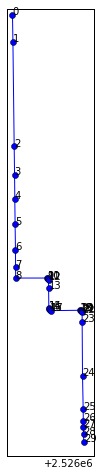

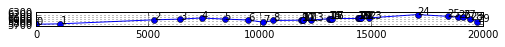

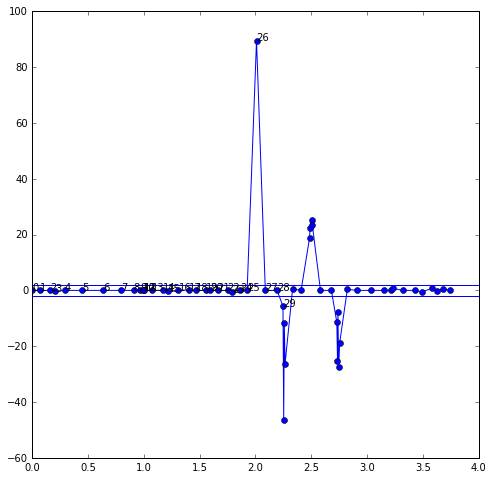

In [96]:
DegMin = 2
MinLen = 0.5*5280
MidPoints = 500
# 33: 2 curves, 44533: short curve at end, 1652 rounabout at end
inv = INV.keys()[121635]
inv = '054  70198 000000'
print(inv)
l = json.loads(INV[inv].JSON)['paths'][0]
pntl = AddMidPoints(l,MidPoints)
a = arcpy.Array(pntl)
pl = arcpy.Polyline(a,arcpy.SpatialReference(102672),True,True)
Res = FindRadius(pl,DegMin,MinLen)
DF = Res[0]
CDF = Res[1]
display(CDF)
display(DF)


# Plot the route
size = 8
x = [i[0] for i in l]
y = [i[1] for i in l]
plt.figure(figsize=(size,size))
CDict = {}
for i,r in DF.iterrows():
    if r['Radius']!=0 and r['Cluster Type']!=2:
        CDict.update({abs(r['Radius']):[r['Center_X'],r['Center_Y']]})
for r in CDict:
    circle = plt.Circle((CDict[r][0],CDict[r][1]),r,facecolor="none")
    plt.gcf().gca().add_artist(circle)

plt.plot(x, y,'-o')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='off') # labels along the bottom edge are off
for i in range(len(l)):
    plt.annotate(str(i),(x[i],y[i]))
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


#Plot the vertical Profile
z = [i[2]*10 for i in l]
m = [i[3]*5280 for i in l]
plt.figure(figsize=(size,size))
plt.plot(m, z,'-o')
for i in range(len(l)):
    plt.annotate(str(i),(m[i],z[i]))
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.ylim = [0,1]
plt.xlim = [0,1]
plt.show()


# Plot the Heading Angle
x = DF['Milepost']
y = DF['Heading Angle']
plt.figure(figsize=(size,size))
plt.plot(x, y,'-o')
plt.axhline(y=-DegMin)
plt.axhline(y=DegMin)
for i in range(len(l)):
    plt.annotate(str(i),(x[i],y[i]))
plt.show()

In [11]:
DF[DF['Cluster Type']==2]

NameError: name 'DF' is not defined